* [Multimodal Retrieval with Text Embedding and CLIP Image Embedding for Backyard Birds](https://levelup.gitconnected.com/multimodal-retrieval-with-text-embedding-and-clip-image-embedding-for-backyard-birds-599f19057a70)

* [Image (embedding) sourcing with retrieval QA ](https://github.com/langchain-ai/langchain/discussions/8921)

![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/0*dFJuZkLnsXEjTU_n.gif "architecture")

In [1]:
import os
import sys 
sys.path.append(r'..')
from utils.database_managers import QDrantDBManager
from utils.embedding import EmbeddingFunction
import torch
import clip
import numpy as np
from PIL import Image
from llama_index.core.schema import ImageDocument

from dotenv import load_dotenv
load_dotenv(override=True)

c:\Users\ELAFACRB1\venvs\langchain\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
embedding = EmbeddingFunction('fast-bgeEmbedding').embedder

Fetching 5 files: 100%|██████████| 5/5 [00:00<00:00, 2728.89it/s]


In [3]:

QDRANT_URL=os.getenv('QDRANT_URL')
COLLECTION_NAME="images"

qdrantClient = QDrantDBManager(
    url=QDRANT_URL,
    port=6333,
    collection_name=COLLECTION_NAME,
    vector_size=512,
    embedding=embedding,
    record_manager_url="sqlite:///record_manager_cache.sql"
)


In [4]:
# load the CLIP model with the name ViT-B/32
model, preprocess = clip.load("ViT-B/32")

In [5]:
# the resolution of the input images expected by the model
input_resolution = model.visual.input_resolution

# the maximum length of the input text
context_length = model.context_length

# the size of the vocabulary used by the model
vocab_size = model.vocab_size

# print the information about the model to the console
print(
    "Model parameters:",
    f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}",
)
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

# set the device to use for the CLIP model, either CUDA (GPU) or CPU, depending on availability
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408
cpu


In [6]:
# image_metadata_dict stores images metadata including filename and path
image_metadata_dict = {}
# Get a list of all the image files in the `images` folder.
image_files = os.listdir("data/images")

# Loop through each image file and add metadata.
for image_file in image_files:
  image_path = os.path.join("data/images", image_file)

  # Get the image filename.
  image_filename = os.path.basename(image_path)

  # Get the image file path.
  image_file_path = os.path.abspath(image_path)

  # Create a dictionary to store the image metadata.
  image_metadata_dict[image_filename] = {
    "filename": image_filename,
    "img_path": image_file_path,
  }

# img_emb_dict stores image embeddings for each image
img_emb_dict = {}

In [7]:
image_metadata_dict

{'pianta.jpg': {'filename': 'pianta.jpg',
  'img_path': 'c:\\Users\\ELAFACRB1\\Codice\\GitHub\\multimodal-rag\\notebooks\\data\\images\\pianta.jpg'},
 'plant_disease.jpg': {'filename': 'plant_disease.jpg',
  'img_path': 'c:\\Users\\ELAFACRB1\\Codice\\GitHub\\multimodal-rag\\notebooks\\data\\images\\plant_disease.jpg'},
 'TRUPPE-CAMMELLATE.jpg': {'filename': 'TRUPPE-CAMMELLATE.jpg',
  'img_path': 'c:\\Users\\ELAFACRB1\\Codice\\GitHub\\multimodal-rag\\notebooks\\data\\images\\TRUPPE-CAMMELLATE.jpg'}}

In [8]:
with torch.no_grad():
    # iterate over the image metadata dictionary and extracts image embeddings for each image
    for image_filename in image_metadata_dict:
        img_file_path = image_metadata_dict[image_filename]["img_path"]
        if os.path.isfile(img_file_path):
            image = (
                # preprocess the image using the CLIP model's preprocess function
                # unsqueeze the image tensor to add a batch dimension
                # move the image tensor to the device specified in line 1
                preprocess(Image.open(img_file_path)).unsqueeze(0).to(device)
            )

            # extract image features using the CLIP model's encode_image function
            image_features = model.encode_image(image)

            # store the image features in the image embedding dictionary
            img_emb_dict[image_filename] = image_features

In [9]:
img_emb_dict

{'pianta.jpg': tensor([[ 1.4576e-01,  6.2332e-01,  2.0993e-01, -3.2803e-01, -3.4508e-01,
           1.1238e-01, -9.9051e-02, -3.2699e-02,  5.1548e-01,  6.0756e-03,
          -1.0603e-03,  3.1949e-01, -2.5250e-01, -4.1909e-01,  3.8422e-01,
          -3.8412e-02,  1.6606e-01, -9.1923e-03,  4.8247e-01, -4.5567e-02,
          -5.7242e-01,  5.6051e-01,  5.6144e-01,  5.0981e-01, -1.5633e-01,
           2.6539e-01,  2.0050e-01, -6.4849e-02,  5.0369e-01,  1.8252e-01,
           5.6538e-01,  1.6246e-01, -1.7286e-01, -1.4663e-01, -3.9906e-02,
          -3.5772e-01,  3.7248e-01,  3.6389e-02,  4.1919e-01,  1.7645e+00,
          -4.0099e-02, -4.5936e-02, -1.2406e-01,  2.8881e-01, -1.6331e-01,
          -1.5549e+00, -8.7837e-01,  3.8911e-01,  1.8585e-01, -5.6671e-02,
           5.7360e-01, -5.2999e-01,  2.1839e-01,  1.1467e-01, -4.3860e-01,
           2.5565e-01, -8.8153e-03, -1.8318e-02,  3.9262e-01,  2.7290e-01,
           1.9362e-01, -3.2572e-01, -7.6968e-02, -1.9753e-02, -3.9945e-01,
          -

In [10]:

# create a list of ImageDocument objects, one for each image in the dataset
img_documents = []
for image_filename in image_metadata_dict:
    # the img_emb_dict dictionary contains the image embeddings
    if image_filename in img_emb_dict:
        
        filename = image_metadata_dict[image_filename]["filename"]
        filepath = image_metadata_dict[image_filename]["img_path"]

        # create an ImageDocument for each image 
        newImgDoc = ImageDocument(
            text=filename, metadata={"filepath": filepath}
        )

        # set image embedding on the ImageDocument
        newImgDoc.embedding = img_emb_dict[image_filename].tolist()[0]
        img_documents.append(newImgDoc)

len(img_documents)

3

In [15]:
qdrantClient.index_llamaindex_documents(qdrantClient.client, COLLECTION_NAME, img_documents)

# Retrieve

In [24]:
from llama_index.core.vector_stores import VectorStoreQuery
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
import matplotlib.pyplot as plt

In [25]:

# take a text query as input and return the most similar image from the vector store
def retrieve_results_from_image_index(query):

    # first tokenize the text query and convert it to a tensor
    text = clip.tokenize(query).to(device)

    # encode the text tensor using the CLIP model to produce a query embedding
    query_embedding = model.encode_text(text).tolist()[0]

    # create a VectorStoreQuery
    image_vector_store_query = VectorStoreQuery(
        query_embedding=query_embedding,
        similarity_top_k=1, # only return 1 image
        mode="default",
    )

    # execute the query against the image vector store
    image_retrieval_results = image_vector_store.query(
        image_vector_store_query
    )
    return image_retrieval_results


# take a list of image retrieval results and create a new figure with a size of 16 by 5 inches
def plot_image_retrieve_results(image_retrieval_results):
    plt.figure(figsize=(16, 5))

    img_cnt = 0
    # iterate over the image retrieval results, and for each result, display the corresponding image and its score in a subplot.
    # The subplot is 2 by 3, and the image is displayed in the img_cnt + 1th subplot.
    # The title of the subplot is the score of the image, formatted to four decimal places.
    for returned_image, score in zip(
        image_retrieval_results.nodes, image_retrieval_results.similarities
    ):
        img_name = returned_image.text
        img_path = returned_image.metadata["filepath"]
        image = Image.open(img_path).convert("RGB")

        plt.subplot(2, 3, img_cnt + 1)
        plt.title("{:.4f}".format(score))

        plt.imshow(image)
        plt.xticks([])
        plt.yticks([])
        img_cnt += 1


# define image_query function
def image_query(query):
    image_retrieval_results = retrieve_results_from_image_index(query)
    text_retrieval 
    plot_image_retrieve_results(image_retrieval_results)

In [30]:
query="what does the camel rider have in their hands?"
image_retrieval_results = retrieve_results_from_image_index(query)
image_retrieval_results

VectorStoreQueryResult(nodes=[ImageNode(id_='dc9e0612-a484-4038-a16c-7b1ab8eb69b9', embedding=None, metadata={'filepath': 'c:\\Users\\ELAFACRB1\\Codice\\GitHub\\multimodal-rag\\notebooks\\data\\images\\TRUPPE-CAMMELLATE.jpg'}, excluded_embed_metadata_keys=[], excluded_llm_metadata_keys=[], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='484b8b11-5fd4-4d4a-99ca-a17dd669b42a', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'filepath': 'c:\\Users\\ELAFACRB1\\Codice\\GitHub\\multimodal-rag\\notebooks\\data\\images\\TRUPPE-CAMMELLATE.jpg'}, hash='6c872d6221db2c25f94b7d15ebb8ef5078e5c0487e497e60489b2b66f1d3c92d')}, text='TRUPPE-CAMMELLATE.jpg', mimetype='text/plain', start_char_idx=0, end_char_idx=21, text_template='{metadata_str}\n\n{content}', metadata_template='{key}: {value}', metadata_seperator='\n', image=None, image_path=None, image_url=None, image_mimetype=None, text_embedding=None)], similarities=[28.171858], ids=['dc9e0612-a484-4038-a16c-7b1ab8eb69b9'])

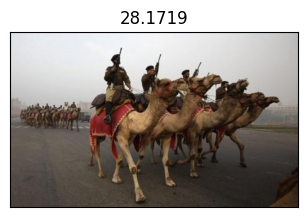

In [31]:
image_query(query)